# Project 1

Author : Behrad Binaei Haghighi

Student ID : 810101392

Let's start by implementing VGG16 and ResNet50 to classify three different skin diseases (Nevus, Melanoma, and Carcinoma) with and without data augmentation. We'll compare the classification report for all four models.

First, let's import the necessary libraries and load the dataset. We'll use TensorFlow and Keras for model building and evaluation.


In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount("/content/drive")

folder_pathes = ["Melanoma" , "Carcinoma", "Nevus"]
category_names = ["Melanoma" , "Carcinoma", "Nevus"]


d = "/content/drive/MyDrive/project1/"

Mounted at /content/drive


### Define Constants

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20

## Preprocessing the Data

As we navigate through the dataset folders randomly, we encounter numerous instances of duplicated samples, which can potentially cause the model to overfit. To address this issue, our preprocessing procedure involves the following steps:

### 1. Removing Duplicated (Repeated) Data:

Duplicate samples are identified and systematically removed from the dataset to mitigate the risk of overfitting.


### 2. Converting Images to Arrays:

All images in the dataset are converted into arrays, facilitating efficient processing and manipulation within the computational environment. And also models doesn't work with pictures so this part is unremoveable.

### 3. Resizing Images to a Uniform Size:

To ensure uniformity and consistency in data representation and using less memory, all images are resized to a standardized dimension, optimizing compatibility for subsequent model training.

### 4. Merging Data from Different Categories:

Data from the three distinct categories are consolidated into a cohesive dataset.




This function does them.

In [ ]:
data_dirs = {
    "Melanoma": d + folder_pathes[0],
    "Nevus": d + folder_pathes[2],
    "Carcinoma": d + folder_pathes[1]
}


def load_data(data_dirs):
    X = []
    y = []

    for label, data_dir in data_dirs.items():
        file_names = []
        for filename in os.listdir(data_dir):
            if filename.endswith(('.png', '.jpg', '.jpeg')) and filename[0:12] not in file_names:

                img = tf.keras.preprocessing.image.load_img(os.path.join(data_dir, filename), target_size=IMG_SIZE)
                img_array = tf.keras.preprocessing.image.img_to_array(img)

                file_names.append(filename[0:12])
                X.append(img_array)
                y.append(label)

    X = np.array(X)
    y = np.array(y)
    return X, y


In [ ]:
X, y = load_data(data_dirs)

### 5. Shuffling and Splitting the Data:

To prevent bias and ensure unbiased model evaluation, the dataset is randomly shuffled. Subsequently, it is partitioned into separate subsets for training, testing, and validation, employing appropriate proportions.



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

### 6. One Hot Encoding:
In order to prepare the categorical target labels for modeling, we employ one-hot encoding. This technique transforms categorical variables into a binary matrix format, where each category is represented by a binary vector.

In [ ]:
label_map = {category: idx for idx, category in enumerate(category_names)}


y_train_encoded = np.array([label_map[label] for label in y_train])
y_test_encoded  = np.array([label_map[label] for label in y_test])


y_train_encoded = tf.keras.utils.to_categorical(y_train_encoded, num_classes=len(category_names))
y_test_encoded  = tf.keras.utils.to_categorical(y_test_encoded, num_classes=len(category_names))

### 7. Data Augmentation:

To enrich the dataset and improve its robustness, data augmentation techniques are applied. This involves generating variations of existing samples by applying transformations such as rotation, flipping, and scaling.


In [ ]:
# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No data augmentation for validation/test set
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(127, 224, 224, 3)
(15, 224, 224, 3)


### Applying Data Augmentation to Train Data

In [ ]:
train_generator = train_datagen.flow(X_train, y_train_encoded, BATCH_SIZE)
test_generator = test_datagen.flow(X_test, y_test_encoded, BATCH_SIZE)

### Architectures of VGG16 and ResNet50:

1. **VGG16 (Visual Geometry Group 16):**
   - VGG16 is a deep convolutional neural network architecture.
   - It consists of 16 weight layers, including 13 convolutional layers and 3 fully connected layers.
   - The convolutional layers use small 3x3 filters with a stride of 1 and 'same' padding, followed by max-pooling layers with 2x2 filters and a stride of 2.
   - The fully connected layers at the end of the network process the extracted features for classification.

2. **ResNet50 (Residual Network with 50 layers):**
   - ResNet50 is a deep residual neural network.
   - It features a unique architecture that includes shortcut connections, or skip connections, which allow gradients to flow more directly through the network during training.
   - The network consists of 50 layers, with a combination of convolutional layers, batch normalization, activation functions, and skip connections.
   

In summary, VGG16 is a deep convolutional network with a straightforward architecture, while ResNet50 introduces skip connections to address training difficulties in very deep networks. Both architectures have been widely used and proven effective in various computer vision tasks, including image classification.

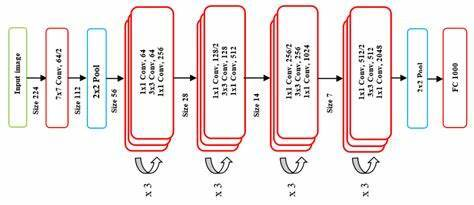

In [4]:
from IPython.display import Image
Image(filename=d+'images/resnet50.jpg',width=950,height=950)

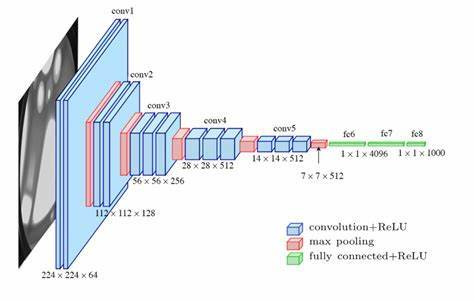

In [5]:
Image(filename=d+'images/vgg16.jpg',width=950,height=950)

In [ ]:
# Load pre-trained models
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Freeze pre-trained model layers
for layer in vgg_model.layers:
    layer.trainable = False

for layer in resnet_model.layers:
    layer.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

vgg_model = tf.keras.Sequential([
    vgg_model,
    global_average_layer,
    tf.keras.layers.Dense(3, activation='softmax')
])

resnet_model = tf.keras.Sequential([
    resnet_model,
    global_average_layer,
    tf.keras.layers.Dense(3, activation='softmax')
])


vgg_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

resnet_model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

94765736/94765736 [==============================] - 0s 0us/step


## Train VGG model with applying Data Augmentation

In [ ]:
vgg_history_aug = vgg_model.fit(train_generator,
                             epochs=EPOCHS,
                             validation_data=test_generator,
                             verbose=1)

Epoch 1/20
4/4 [==============================] - 20s 4s/step - loss: 1.6602 - accuracy: 0.2992 - val_loss: 1.7219 - val_accuracy: 0.2000
Epoch 2/20
4/4 [==============================] - 2s 388ms/step - loss: 1.4697 - accuracy: 0.2992 - val_loss: 1.5219 - val_accuracy: 0.2000
Epoch 3/20
4/4 [==============================] - 2s 413ms/step - loss: 1.3396 - accuracy: 0.2992 - val_loss: 1.3640 - val_accuracy: 0.2000
Epoch 4/20
4/4 [==============================] - 2s 395ms/step - loss: 1.2365 - accuracy: 0.3071 - val_loss: 1.2513 - val_accuracy: 0.2667
Epoch 5/20
4/4 [==============================] - 2s 408ms/step - loss: 1.1703 - accuracy: 0.2913 - val_loss: 1.1776 - val_accuracy: 0.2667
Epoch 6/20
4/4 [==============================] - 2s 388ms/step - loss: 1.1348 - accuracy: 0.3780 - val_loss: 1.1289 - val_accuracy: 0.2667
Epoch 7/20
4/4 [==============================] - 3s 642ms/step - loss: 1.1194 - accuracy: 0.3543 - val_loss: 1.0970 - val_accuracy: 0.4000
Epoch 8/20
4/4 [======

## Train ResNet Model with applying Data Augmentation

In [ ]:
resnet_history_aug = resnet_model.fit(train_generator,
                                   epochs=EPOCHS,
                                   validation_data=test_generator,
                                   verbose=2)

Epoch 1/20
4/4 - 12s - loss: 1.1892 - accuracy: 0.3465 - val_loss: 1.1008 - val_accuracy: 0.4000 - 12s/epoch - 3s/step
Epoch 2/20
4/4 - 2s - loss: 1.1172 - accuracy: 0.2835 - val_loss: 1.1226 - val_accuracy: 0.4000 - 2s/epoch - 394ms/step
Epoch 3/20
4/4 - 2s - loss: 1.1096 - accuracy: 0.3307 - val_loss: 1.0800 - val_accuracy: 0.4000 - 2s/epoch - 384ms/step
Epoch 4/20
4/4 - 2s - loss: 1.0954 - accuracy: 0.3622 - val_loss: 1.0740 - val_accuracy: 0.4000 - 2s/epoch - 403ms/step
Epoch 5/20
4/4 - 3s - loss: 1.1045 - accuracy: 0.3543 - val_loss: 1.0710 - val_accuracy: 0.4000 - 3s/epoch - 646ms/step
Epoch 6/20
4/4 - 2s - loss: 1.1030 - accuracy: 0.2913 - val_loss: 1.0866 - val_accuracy: 0.4000 - 2s/epoch - 395ms/step
Epoch 7/20
4/4 - 2s - loss: 1.1003 - accuracy: 0.3622 - val_loss: 1.0938 - val_accuracy: 0.4000 - 2s/epoch - 387ms/step
Epoch 8/20
4/4 - 1s - loss: 1.0976 - accuracy: 0.3858 - val_loss: 1.0789 - val_accuracy: 0.4667 - 1s/epoch - 375ms/step
Epoch 9/20
4/4 - 2s - loss: 1.0947 - accu

## Evaluate models

In [ ]:
vgg_loss, vgg_accuracy = vgg_model.evaluate(X_test, y_test_encoded, verbose=0)
resnet_loss, resnet_accuracy = resnet_model.evaluate(X_test, y_test_encoded, verbose=0)

print("VGG16 Model Evaluation:")
print("Loss:", vgg_loss)
print("Accuracy:", vgg_accuracy)

print("\nResNet50 Model Evaluation:")
print("Loss:", resnet_loss)
print("Accuracy:", resnet_accuracy)


VGG16 Model Evaluation:
Loss: 1.0092664957046509
Accuracy: 0.5333333611488342

ResNet50 Model Evaluation:
Loss: 1.9406546354293823
Accuracy: 0.3333333432674408


## Training the model with the raw data

In [ ]:
vgg_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

resnet_model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

vgg_history_raw = vgg_model.fit(X_train,
                                y_train_encoded,
                             epochs=EPOCHS,
                             validation_data=(X_test, y_test_encoded),
                             verbose=1)

resnet_history_raw = resnet_model.fit(X_train,
                                      y_train_encoded,
                                   epochs=EPOCHS,
                                   validation_data=(X_test, y_test_encoded),
                                   verbose=2)

Epoch 1/20
4/4 [==============================] - 2s 225ms/step - loss: 1.9269 - accuracy: 0.4646 - val_loss: 0.9238 - val_accuracy: 0.4000
Epoch 2/20
4/4 [==============================] - 1s 149ms/step - loss: 1.7216 - accuracy: 0.4646 - val_loss: 0.8675 - val_accuracy: 0.4667
Epoch 3/20
4/4 [==============================] - 1s 151ms/step - loss: 1.5486 - accuracy: 0.4961 - val_loss: 0.7715 - val_accuracy: 0.4667
Epoch 4/20
4/4 [==============================] - 1s 148ms/step - loss: 1.3837 - accuracy: 0.5118 - val_loss: 0.7343 - val_accuracy: 0.4667
Epoch 5/20
4/4 [==============================] - 1s 150ms/step - loss: 1.2420 - accuracy: 0.5276 - val_loss: 0.6941 - val_accuracy: 0.5333
Epoch 6/20
4/4 [==============================] - 1s 147ms/step - loss: 1.1209 - accuracy: 0.5827 - val_loss: 0.6841 - val_accuracy: 0.6000
Epoch 7/20
4/4 [==============================] - 1s 148ms/step - loss: 1.0139 - accuracy: 0.5984 - val_loss: 0.6609 - val_accuracy: 0.6667
Epoch 8/20
4/4 [====

### Ploting the loss

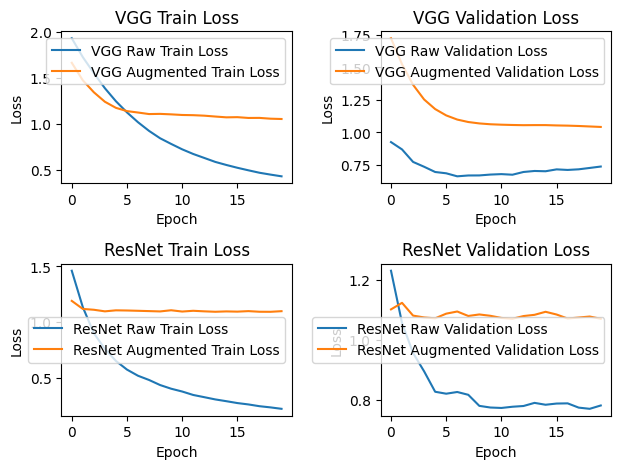

In [ ]:
# Plot VGG train loss
plt.subplot(2, 2, 1)
plt.plot(vgg_history_raw.history['loss'], label='VGG Raw Train Loss')
plt.plot(vgg_history_aug.history['loss'], label='VGG Augmented Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VGG Train Loss')
plt.legend()

# Plot VGG validation loss
plt.subplot(2, 2, 2)
plt.plot(vgg_history_raw.history['val_loss'], label='VGG Raw Validation Loss')
plt.plot(vgg_history_aug.history['val_loss'], label='VGG Augmented Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VGG Validation Loss')
plt.legend()

# Plot ResNet train loss
plt.subplot(2, 2, 3)
plt.plot(resnet_history_raw.history['loss'], label='ResNet Raw Train Loss')
plt.plot(resnet_history_aug.history['loss'], label='ResNet Augmented Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResNet Train Loss')
plt.legend()

# Plot ResNet validation loss
plt.subplot(2, 2, 4)
plt.plot(resnet_history_raw.history['val_loss'], label='ResNet Raw Validation Loss')
plt.plot(resnet_history_aug.history['val_loss'], label='ResNet Augmented Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResNet Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


### Classification reports

### Explanation of the Codes for VGG16 and ResNet50 with Data Augmentation

Data augmentation is a technique used to increase the diversity of training data by applying various transformations such as rotation, flipping, scaling, etc. This helps in improving the generalization ability of the model and reducing overfitting. We'll apply data augmentation to both VGG16 and ResNet50 models using TensorFlow's `ImageDataGenerator`.


In these code snippets, we define separate `ImageDataGenerator` objects for both VGG16 and ResNet50 models with the desired augmentation parameters such as rotation_range, width_shift_range, height_shift_range, shear_range, zoom_range, horizontal_flip, and fill_mode.

### Advantages and Disadvantages of Data Augmentation in Convolutional Neural Networks

**Advantages:**
1. **Increased Dataset Size:** Data augmentation allows us to generate additional training samples from existing ones, effectively increasing the size of the dataset. This can help improve the generalization of the model and reduce overfitting.
2. **Improved Robustness:** By exposing the model to various transformations of the input data during training, data augmentation helps the model become more robust to variations and distortions in the input images, leading to better performance on unseen data.
3. **Reduced Memorization:** Data augmentation encourages the model to learn more invariant features, rather than memorizing specific details of the training images. This leads to better generalization to new, unseen images.

**Disadvantages:**
1. **Computation Overhead:** Augmenting the training data on-the-fly during training can introduce additional computational overhead, especially when dealing with large datasets and complex augmentation strategies. This can increase training time and resource requirements.
2. **Potential Overfitting:** While data augmentation can help prevent overfitting by increasing the diversity of the training data, inappropriate augmentation strategies or excessive augmentation can lead to overfitting on the augmented data, reducing the model's ability to generalize to unseen data.
3. **Loss of Semantic Information:** Some augmentation techniques, such as random cropping or resizing, may alter the semantic information of the input images. This can potentially degrade the quality of the augmented data and affect the model's performance.

Overall, when used judiciously, data augmentation is a powerful technique for improving the performance and robustness of convolutional neural networks. However, it's important to carefully choose and tune the augmentation strategies based on the characteristics of the dataset and the requirements of the task.